<a href="https://colab.research.google.com/github/patmull/alex-karpathy-tutorials/blob/main/build_makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-10-03 07:26:45--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2023-10-03 07:26:45 (5.49 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one. NOTICE: If we change this, the shape dimensions will change.

def build_dataset(words):
  X, Y = [], []
  for w in words:

    # print(f"w: {w}")
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2]) # ( = validation set)
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
(Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype)

(torch.Size([182625, 3]), torch.int64, torch.Size([182625]), torch.int64)

In [9]:
Xtr

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        ...,
        [15, 12,  4],
        [12,  4,  1],
        [ 4,  1, 14]])

In [10]:
Ytr

tensor([25, 21,  8,  ...,  1, 14,  0])

In [11]:
Ytr.shape

torch.Size([182625])

In [12]:
GENERATOR_SEED = 2147483647  # for reproducibility
g = torch.Generator().manual_seed(GENERATOR_SEED)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [13]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [14]:
for p in parameters:
  p.requires_grad = True

In [15]:
C.shape

torch.Size([27, 10])

In [16]:
C[2] # Thes values are from the Tensor above (only not rounded)

tensor([ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
        -1.2199,  0.3031], grad_fn=<SelectBackward0>)

In [17]:
# We can also do the selection effectively using the One Hot Encoding method
f_one_hot = F.one_hot(torch.tensor(2), num_classes=27)
print(f_one_hot)
print(f_one_hot.float() @ C)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])
tensor([ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
        -1.2199,  0.3031], grad_fn=<SqueezeBackward4>)


In [18]:
## PyTorch tensors indexing
print(C[torch.tensor([2,6,7])])
print(C[torch.tensor([2,2,2,2,2,6,7,7,7,2])])
print(f"C dimensions: {C.shape}")
print(f"Xtr dimensions: {Xtr.shape}")
print(f"C[Xtr] dimensions: {C[Xtr].shape}") # [182424, 3, 10]. z=10 is embedding vector from the C. x, y are the Xtr dimensions
print(C[Xtr])
example_location = Xtr[4, 2]
print("Selecting individual integer from the tensor: ", example_location, example_location.item())
print(C[Xtr][4,2])
print("This is == to selecting by the example_location.item():")
print(C[example_location.item()])

tensor([[ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
         -1.2199,  0.3031],
        [ 0.1351, -0.2116, -1.0406, -1.5367,  0.9374, -0.8830,  1.7457,  2.1346,
         -0.8561,  0.5408],
        [ 0.6169,  1.5160, -1.0447, -0.6641, -0.7239,  1.7507,  0.1753,  0.9928,
         -0.6279,  0.0770]], grad_fn=<IndexBackward0>)
tensor([[ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
         -1.2199,  0.3031],
        [ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
         -1.2199,  0.3031],
        [ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
         -1.2199,  0.3031],
        [ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
         -1.2199,  0.3031],
        [ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
         -1.2199,  0.3031],
        [ 0.1351, -0.2116, -1.0406, -1.5367,  0.9374, -0.8830,  1.7457,  2.1346,
         -0.8561,  0

In [19]:
emb = C[Xtr]
emb.shape

torch.Size([182625, 3, 10])

In [20]:
W_x_shape = emb.shape[0] * emb.shape[2] # * emb.shape[2]
W_y_shape = 100 # Chosen some meaningul value
print(f"W_x_shape: {W_x_shape}")
W = torch.randn((W_x_shape, W_y_shape))
W

W_x_shape: 1826250


tensor([[ 0.5716,  1.8084,  0.9752,  ...,  1.6933,  0.3253,  0.3834],
        [ 0.3865, -0.1487, -0.6291,  ...,  0.8707, -0.7697,  0.0992],
        [ 0.7620,  1.5228, -0.0548,  ..., -0.1419, -0.1036, -0.7217],
        ...,
        [-0.1539, -1.2765, -0.2216,  ..., -0.2401,  2.0253,  0.8696],
        [ 0.2348,  0.5191,  1.6833,  ...,  0.7447, -0.0800, -0.2927],
        [-0.7104, -1.0585,  0.7370,  ...,  0.4964,  1.0021,  1.0165]])

In [22]:
# What we want. WARNING: This will produce an error due to the uncompatible shape
# emb @ W1 + b1
# What we need
# Those are the 3 embeddings selected (the very first "nodes" of the NN, see the picture in the original MLP paper or Andrej's video)
print(emb[:, 0, :].size())
print(emb[:, 1, :].size())
print(emb[:, 2, :].size())
# Concatination of the tensors together in order to edit the shape
concat_embeddings = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1) # Now the shape is what we need
print(concat_embeddings.size())

torch.Size([182625, 10])
torch.Size([182625, 10])
torch.Size([182625, 10])
torch.Size([182625, 30])


In [23]:
torch.unbind(emb, 1)

(tensor([[ 1.5674, -0.2373, -0.0274,  ...,  0.6049,  0.0791,  0.9046],
         [ 1.5674, -0.2373, -0.0274,  ...,  0.6049,  0.0791,  0.9046],
         [ 1.5674, -0.2373, -0.0274,  ...,  0.6049,  0.0791,  0.9046],
         ...,
         [ 0.5557,  0.4746, -1.3867,  ...,  1.0198, -1.9062, -0.4275],
         [-0.5614, -0.1375, -0.1380,  ..., -0.5103,  0.5642,  0.9684],
         [-0.9648, -0.2321, -0.3476,  ...,  0.4585,  0.0540, -1.7400]],
        grad_fn=<UnbindBackward0>),
 tensor([[ 1.5674, -0.2373, -0.0274,  ...,  0.6049,  0.0791,  0.9046],
         [ 1.5674, -0.2373, -0.0274,  ...,  0.6049,  0.0791,  0.9046],
         [-1.2801,  0.0924,  0.1053,  ..., -0.8163, -0.3924, -0.7452],
         ...,
         [-0.5614, -0.1375, -0.1380,  ..., -0.5103,  0.5642,  0.9684],
         [-0.9648, -0.2321, -0.3476,  ...,  0.4585,  0.0540, -1.7400],
         [-0.4713,  0.7868, -0.3284,  ..., -1.6261,  0.6772, -0.8404]],
        grad_fn=<UnbindBackward0>),
 tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-0

In [24]:
torch.cat(torch.unbind(emb, 1), 1).shape # we finally have same result as before (but with much better SW engineering practises)

torch.Size([182625, 30])

In [25]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [26]:
## EFFICIENTY OF TORCH
a.storage() # this is TOrch in memory
# TODO: What is the purpose f a.view()?


<ipython-input-26-1fb01bc2b505>:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage() # this is TOrch in memory


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [27]:
print(a.view(9,2)) # representing the 'a' as a different size tensor
print(a.view(3,3,2))

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])
tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])


In [33]:
# The equality of using the previous approch of concatinating the embeddings and the view() method
torch.cat(torch.unbind(emb, 1), 1) == emb.view(182625, 30)

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [34]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
emb_view_X_dim = 182625


In [70]:
## Hidden layer
Xtr_x_dim = Xtr.shape[0]
Xtr_x_dim


182625

In [71]:
torch.arange(Xtr_x_dim)

tensor([     0,      1,      2,  ..., 182622, 182623, 182624])

In [72]:
b_tr = torch.randn(Xtr_x_dim)
b_tr.shape

torch.Size([182625])

In [62]:
emb = C[Xtr]
emb.view(-1, Xtr_x_dim)

tensor([[ 1.6239,  0.3657,  0.0282,  ...,  0.2180,  0.5837, -0.7261],
        [-0.6123, -1.1945,  0.7051,  ..., -0.1436,  0.1029, -0.3004],
        [ 1.6239,  0.3657,  0.0282,  ..., -0.5034, -1.1575, -0.5403],
        ...,
        [ 0.3271, -1.2354,  0.8124,  ..., -0.6756, -0.0305, -0.7408],
        [-0.3869, -0.1468, -0.5034,  ..., -0.2017, -0.2871, -0.2076],
        [ 0.7470,  0.3676,  0.2818,  ...,  0.2818, -0.1661, -0.5096]],
       grad_fn=<ViewBackward0>)

In [104]:
### HIDDEN LAYER
print(emb.shape)
emb_y_z_dim = emb.shape[1]*emb.shape[2]
W1 = torch.randn(emb_y_z_dim, W_y_shape)
b1 = torch.randn(W_y_shape)
print(W1.shape)
print(b1.shape)
print(emb.view(emb.shape[0], emb_y_z_dim).shape)
h = emb.view(emb.shape[0], emb_y_z_dim) @ W1 + b1
h = torch.tanh(h)
h

torch.Size([182625, 3, 10])
torch.Size([30, 100])
torch.Size([100])
torch.Size([182625, 30])


tensor([[-0.9804, -0.9481,  0.9914,  ...,  0.9995,  0.9810,  0.5214],
        [-0.5557, -0.5430, -0.9122,  ...,  0.9531,  0.9827, -0.6871],
        [ 0.9675, -0.3567,  0.5731,  ..., -0.9372,  0.9961, -0.9396],
        ...,
        [ 0.9998, -0.2658, -0.8588,  ..., -0.9989,  0.9902,  0.7910],
        [ 0.9982,  0.4910, -1.0000,  ...,  0.9999,  0.9999, -0.4132],
        [ 0.9994,  0.9882, -0.9295,  ...,  0.9997,  0.6117,  0.7509]],
       grad_fn=<TanhBackward0>)

In [109]:
### OUTPUT LAYER
POSSIBLE_CHARS = 27
W2 = torch.randn((W_y_shape, POSSIBLE_CHARS))
b2 = torch.randn(POSSIBLE_CHARS)

In [111]:
logits = h @ W2 + b2
logits.shape

torch.Size([182625, 27])

In [128]:
counts = logits.exp()
counts.shape

torch.Size([182625, 27])

In [129]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([182625, 27])

In [115]:
# see that probs are normalized (= summing to 1)
prob[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [ ]:
## PREDICTING THE Y

In [118]:
# Reminder of the main goal: we want to predict the Y
Ytr
Ytr.shape

torch.Size([182625])

In [124]:
# Like in the case of Bigrams lang. model, we want to index each row ang plug out the correct probability for the given character
rows_indexes = torch.arange(Ytr.shape[0]) # This will select the necessary rows
rows_indexes

tensor([     0,      1,      2,  ..., 182622, 182623, 182624])

In [126]:
prob[rows_indexes, Ytr]
# You can see very low probabilities here. But we haven't trained the network yet, so this is expected.

tensor([4.0319e-12, 1.6939e-16, 1.2945e-06,  ..., 4.8899e-13, 3.1018e-16,
        7.7022e-01], grad_fn=<IndexBackward0>)

In [127]:
loss = -prob[rows_indexes, Ytr].log().mean()
loss

tensor(18.8370, grad_fn=<NegBackward0>)

In [35]:
lri = []
lossi = []
stepi = []

In [139]:
for i in range(1000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  # Old way:
  """
  rows_indexes = torch.arange(Ytr[ix].shape[0])
  counts = logits.exp()
  prob = counts / counts.sum(1, keepdims=True)
  loss = -prob[rows_indexes, Ytr[ix]].log().mean()
  """
  # New way:
  loss = F.cross_entropy(logits, Ytr[ix])

  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()



14.424185752868652
16.874921798706055
17.685800552368164
14.90078353881836
16.720321655273438
13.407326698303223
15.338845252990723
16.977643966674805
15.087929725646973
15.533321380615234
15.386523246765137
15.28035831451416
15.268209457397461
17.140880584716797
20.024568557739258
17.22852897644043
15.10047435760498
19.893247604370117
19.888885498046875
15.973905563354492
15.372411727905273
12.55702018737793
14.817347526550293
15.65913200378418
18.360599517822266
14.590165138244629
17.1221923828125
16.494861602783203
16.553804397583008
15.718280792236328
17.23801040649414
15.09212875366211
18.32190704345703
15.759593963623047
16.05760955810547
16.77733039855957
20.433744430541992
19.718149185180664
15.99337100982666
17.102367401123047
16.217636108398438
16.42728042602539
18.40416145324707
13.860017776489258
16.330263137817383
15.509549140930176
16.197355270385742
16.884937286376953
17.343185424804688
15.42184066772461
15.610081672668457
14.404385566711426
16.227209091186523
16.7766036

In [136]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  # Old way:
  rows_indexes = torch.arange(Ytr[ix].shape[0])
  counts = logits.exp()
  prob = counts / counts.sum(1, keepdims=True)
  loss = -prob[rows_indexes, Ytr[ix]].log().mean()

  # New way:
  # loss = F.cross_entropy(logits, Ytr[ix])

  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

17.340890884399414


TypeError: ignored

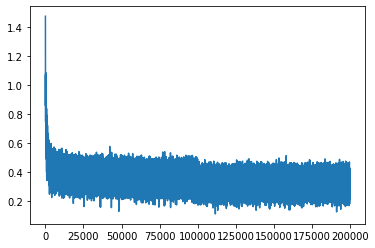

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1335, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1635, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1637, grad_fn=<NllLossBackward0>)

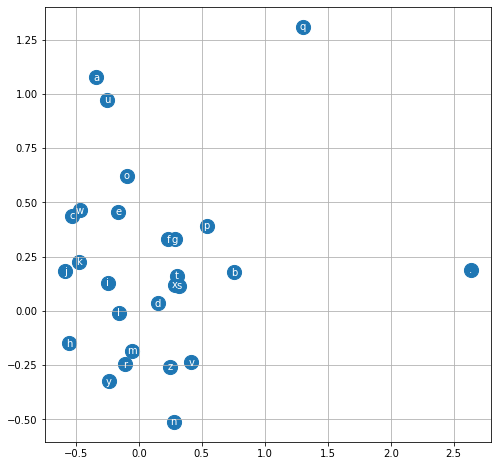

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carmah.
ambril.
khi.
mili.
thylahnanden.
jazhnen.
deliah.
jareei.
ner.
kentzeriiv.
kaleigh.
ham.
jory.
quint.
shon.
marian.
quinteron.
jarynn.
jaxen.
dus.
